In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

from gpaw import GPAW
from ase.build import graphene

import abtem

(examples:hbn_dft_iam)=
# DFT vs. IAM in hBN diffraction 

In [3]:
atoms = graphene(a=2.504, vacuum=2)
atoms[0].number = 5
atoms[1].number = 7
atoms.pbc = True

In [4]:
gpaw = GPAW(h=.2, txt=None, kpts=(3, 3, 3), xc='PBE')
atoms.calc = gpaw
atoms.get_potential_energy()

/home/jacob/miniconda3/envs/abtem-dask/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: convert_string_to_fd does not facilitate proper resource management.  Please use e.g. ase.utils.IOContext class instead.
  warnings.warn(warning)


-17.617064365255825

In [5]:
gpaw_potential = abtem.GPAWPotential(gpaw, sampling=0.05, slice_thickness=.5, gridrefinement=(4,4,2))
gpaw_potential = gpaw_potential.build().compute()

[########################################] | 100% Completed |  1.4s


In [6]:
iam_potential = abtem.Potential(gpaw.atoms, sampling=0.05, projection='finite', slice_thickness=.5)
iam_potential = iam_potential.build().compute()

[########################################] | 100% Completed |  0.6s


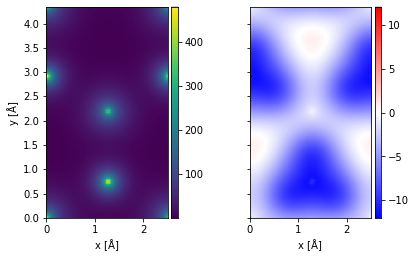

In [15]:
fig = plt.figure()

axes = ImageGrid(fig, 111, (1, 2), cbar_mode='each', axes_pad=1, cbar_pad=0.05)

gpaw_potential.show(ax=axes[0], cbar=True)

(gpaw_potential.project() - iam_potential.project()).show(cbar=True, cmap='bwr', vmin=-12, vmax=12, ax=axes[1]);

In [16]:
gpaw_potential = abtem.from_zarr('pot_gpaw_md.zarr').compute()
iam_potential = abtem.from_zarr('pot_iam_md.zarr').compute()

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


In [17]:
iam_diffraction = abtem.PlaneWave(energy=100e3).multislice(iam_potential).diffraction_patterns(max_angle=60, block_direct=True, parity='odd').mean(0).compute()
gpaw_diffraction = abtem.PlaneWave(energy=100e3).multislice(gpaw_potential).diffraction_patterns(max_angle=60, block_direct=True, parity='odd').mean(0).compute()

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.0s


In [19]:
stacked = abtem.stack((iam_diffraction, gpaw_diffraction), axis_metadata=abtem.axes.OrdinalAxis(values=('IAM', 'GPAW')))

/mnt/c/Users/jacob/PycharmProjects/abTEM_dask/abtem/visualize/mpl.py:424: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)


(<Figure size 576x576 with 4 Axes>,
 <mpl_toolkits.axes_grid1.mpl_axes.Axes at 0x7ff260345c40>)

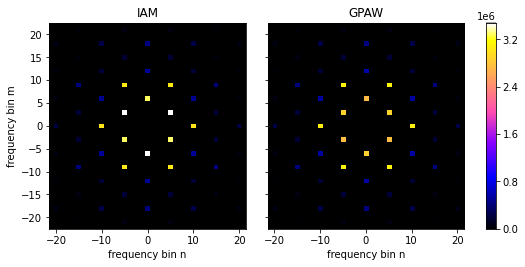

In [20]:
stacked.show(explode=True, 
             common_color_scale=True, 
             cbar=True, 
             figsize=(8,8), 
             cmap='gnuplot2', 
             vmin=.00005,
             units='bins')

In [21]:
import pandas as pd

repetitions = (5,3)
bins = ((0, 2), (0,-2), (1,3), (0,4), (2,2))
bins = tuple((b[0] * repetitions[0], b[1] * repetitions[1]) for b in bins)

data = {}
data['(n, m)'] = [str(bin) for bin in bins[1:]]

data['exp.'] = [1.05, 1.07, 0.19, 0.19]

gpaw_values = gpaw_diffraction.select_frequency_bin(bins)
data['gpaw'] = [f'{value:.2f}' for value in gpaw_values[1:] / gpaw_values[0]]

iam_values = iam_diffraction.select_frequency_bin(bins)
data['iam'] = [f'{value:.2f}' for value in iam_values[1:] / iam_values[0]]

df = pd.DataFrame(data)
df

,"(n, m)",exp.,gpaw,iam
0,"(0, -6)",1.05,1.05,1.05
1,"(5, 9)",1.07,1.15,0.93
2,"(0, 12)",0.19,0.21,0.16
3,"(10, 6)",0.19,0.20,0.15


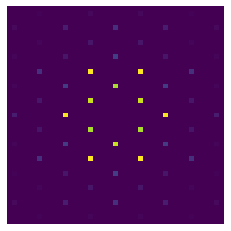

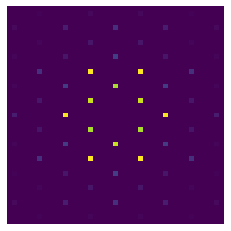

In [26]:
from myst_nb import glue

fig, ax = stacked[1].show(figsize=(4,4))
ax.axis('off');

glue("hbn_dft_iam", ax.get_figure(), display=False)